# End-to-end project: Analyzing NYC High School Data

This project is one of the 2 huge projects that walkthrough from the beginning of data collection till the very end of data analysis. 

One of the most controversial issues in the U.S educational system is the efficacy of standardized tests, and whether they are unfair to certain groups. The SAT, which is short for Scholastic Aptitude Test, is an exam that the U.S high school students take before applying to colleges and universities. The institutes take the test results into account when deciding who to admit, so it's fairly important to perform well on it. We then investigate the correlations between SAT scores and demographics to check if it is the case. We could correlate the SAT scores with factors such as race, gender, income and more. 

Since it has been recently modified so the the combined score of SAT test is 1600, the data set for our project s based on 2,400 total points. You can find the dataset [here](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4). Since it is not enough having one dataset for the whole analysis, we'll need to suplement our data with other sources to do our full analysis. The same website has several related data sets covering demographic information and test scores. 
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
- [School surveys](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

## Background research

1. Only high school stduents take the SAT, so we'll want to focus on high schools only. Our datasets include several different types of schools so that we need to clean them and focus on high schools only. 
2. New York city is made up of 5 boroughs, which are esentially distinct regions.
3. New York City schools fall within several different school districts, each of which can contain dozens of schools. Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.
4. Each school in New York City has a unique code called a DBN, or district borough number. 

## Explore data sets

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "SAT_results.csv"
]
data ={}

# read each file into each dataframe and store all dataframes in a dictionary
# this helps in storing and quick reference later on

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    key_name = f.replace(".csv", "")
    data[key_name] = d
    
data

{'ap_2010':         DBN                                         SchoolName  \
 0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
 1    01M450                             EAST SIDE COMMUNITY HS   
 2    01M515                                LOWER EASTSIDE PREP   
 3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
 4    02M296              High School of Hospitality Management   
 ..      ...                                                ...   
 253  31R605                         STATEN ISLAND TECHNICAL HS   
 254  32K545                      EBC-HS FOR PUB SERVICE (BUSH)   
 255  32K552                          Academy of Urban Planning   
 256  32K554               All City Leadership Secondary School   
 257  32K556  Bushwick Leaders High School for Academic Exce...   
 
      AP Test Takers   Total Exams Taken  Number of Exams with scores 3 4 or 5  
 0               39.0               49.0                                  10.0  
 1               19.0

We're mainly interested in the SAT data set, which corresponds to the dictionary key SAT_results. Let's explore SAT_results to see what we can discover. 

In [2]:
print(data["SAT_results"].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

We can make some observations based on this output:
- The DBN is the unique ID for each school
- From the first few rows of SAT_results dataframe, we can see that we only have high schools.
- There is only a single row for each high school. so each DBN is unique in the SAT data. 
- We may eventually want to combine the 3 columns that contain SAT scores ("SAT Writing Avg. Score", "SAT Critical Reading Avg. Score", "SAT Math Avg. Score") into a single column to make the scores easier to analyze.

Besides that, let's explore the reamaining data to see if we can gain any insight into how to combine them.

In [3]:
for key_name in data:
    print(data[key_name].head())

      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K     

We can make some observations based on the first few rows of each one:
- Each data set appear to either have a DBN column, or the information we need to create one. That means that we can use this column for aggregation. 
- Some fields look interesting for mapping - particularly "Location 1", which contains inside a larger string. 
- Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). This means that we have to do some preprocessing to ensure that each DBN is unique within each data set (for combing). 

Before jumping right in with the merge, we should make sure that we have all of the data we want to unify. This includes "survey_all.txt" and "survey_d75.txt". We did not read these files at first because they are in different format, a bit more complexed format.

In [4]:
with open('schools/survey_all.txt') as f:
    print(f)

<_io.TextIOWrapper name='schools/survey_all.txt' mode='r' encoding='cp1252'>


In [5]:
with open('schools/survey_d75.txt') as f:
    print(f)

<_io.TextIOWrapper name='schools/survey_d75.txt' mode='r' encoding='cp1252'>


As can be seen above, the 2 files "survey_all.txt" and "survey_d75.txt" have quite strange encoding: "cp1252". With a bit of Googling, we come to know that this is Windows-1252 encoding. As of April 2020, 0.4% of all web sites declared use of Windows-1252, but at the same time 2.2% used ISO 8859-1 (0.9% of top-1000 websites), which by HTML5 standards should be considered the same encoding, so that 2.6% of web sites effectively use Windows-1252. We then read these 2 files into a single dataframe. 

In [6]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter ="\t", encoding="windows-1252")
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter ="\t", encoding="windows-1252") 

survey =pd.concat([all_survey, d75_survey], axis=0)

print(survey.head())

C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


     N_p    N_s   N_t  aca_p_11  aca_s_11  aca_t_11  aca_tot_11    bn  \
0   90.0    NaN  22.0       7.8       NaN       7.9         7.9  M015   
1  161.0    NaN  34.0       7.8       NaN       9.1         8.4  M019   
2  367.0    NaN  42.0       8.6       NaN       7.5         8.0  M020   
3  151.0  145.0  29.0       8.5       7.4       7.8         7.9  M034   
4   90.0    NaN  23.0       7.9       NaN       8.1         8.0  M063   

   com_p_11  com_s_11  ...  t_q8c_1  t_q8c_2  t_q8c_3 t_q8c_4  t_q9  t_q9_1  \
0       7.6       NaN  ...     29.0     67.0      5.0     0.0   NaN     5.0   
1       7.6       NaN  ...     74.0     21.0      6.0     0.0   NaN     3.0   
2       8.3       NaN  ...     33.0     35.0     20.0    13.0   NaN     3.0   
3       8.2       5.9  ...     21.0     45.0     28.0     7.0   NaN     0.0   
4       7.9       NaN  ...     59.0     36.0      5.0     0.0   NaN    10.0   

   t_q9_2  t_q9_3  t_q9_4  t_q9_5  
0    14.0    52.0    24.0     5.0  
1     6.0     

There are 2 immediate facts that we can see in the data:
- There are over 2000 columns, nearly all of which we don't actually need. We'll need to filter the data to remove the unecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
- The survey has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistemnt with the other data sets.


## Cleaning the data for analysis

### Survey data set

Along with the file we download from the data source, there is a dictionary enclosed showing what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use. 

Based on the dictionary, it looks like these are the relevant columns: ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

Before we filter columns out, we'll want to copy the data from the dbn column into a new column called "DBN". 

In [7]:
# copy the data from the dbn column of survey into a new column in survey called DBN
survey['DBN'] = survey['dbn']

In [8]:
# filter survey dataframe so that it contains only the columns we listed above
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]
data["survey"] = survey

survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Data columns (total 23 columns):
DBN           1702 non-null object
rr_s          1041 non-null float64
rr_t          1702 non-null int64
rr_p          1702 non-null int64
N_s           1036 non-null float64
N_t           1700 non-null float64
N_p           1696 non-null float64
saf_p_11      1696 non-null float64
com_p_11      1696 non-null float64
eng_p_11      1696 non-null float64
aca_p_11      1696 non-null float64
saf_t_11      1700 non-null float64
com_t_11      1700 non-null float64
eng_t_11      1700 non-null float64
aca_t_11      1700 non-null float64
saf_s_11      1036 non-null float64
com_s_11      1036 non-null float64
eng_s_11      1036 non-null float64
aca_s_11      1036 non-null float64
saf_tot_11    1702 non-null float64
com_tot_11    1702 non-null float64
eng_tot_11    1702 non-null float64
aca_tot_11    1702 non-null float64
dtypes: float64(20), int64(2), object(1)
memory usage: 319.1+ KB


When we did data exploration, we noticed that some data sets did not have a 'DBN' column (class_size and hs_directory). In particular, hs_directory does have a 'dbn' column, though, so we can just rename it.  However, class_size does not appear to have that column at all. 

### Class_size and hs_directory data sets

In [9]:
# first few rows of class_size dataframe
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


From looking at these rows of class_size, we can tell that the DBN is just a combination of CSD and SCHOOL CODE columns. The main difference is that DBN is padded, so that the CSD portion of it alwayds consists of 2 digits. That means that we'll need to add a leading 0 to the CSD if CSD is less than 2 digits long. We'll then modify these 2 dataframes: hs_directory and class_size.

In [10]:
# change dbn into DBN column in hs_directory
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

In [11]:
# create a new column in class_size dataframe with modified CSD (into 2 digits)
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(lambda num: str(num).zfill(2))

data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

print(data["class_size"].head())
print(data["class_size"]["DBN"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Now all dataframe have a DBN column. As mentioned above, we will combine all SAT component scores into a single column that contains the total SAT scores. 

### SAT_results data set

In [12]:
data["SAT_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


As we all know that object is a one-size-fit-all data type, we then need first to convert them into a numeric data type. This is due to the fact that if these 3 columns remain the same type 'object', we may likely not able to add them up together. 

In [13]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["SAT_results"][c] = pd.to_numeric(data["SAT_results"][c], errors="coerce")

data['SAT_results']['sat_score'] = data['SAT_results'][cols[0]] + data['SAT_results'][cols[1]] + data['SAT_results'][cols[2]]
print(data['SAT_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


Next, we'll want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. 

### Parse latitude and longitude coordinates 

In [14]:
print(data["hs_directory"].head())

      dbn                                        school_name    borough  \
0  21K540                             John Dewey High School   Brooklyn   
1  15K429                 Brooklyn School for Global Studies   Brooklyn   
2  24Q530  International High School at LaGuardia Communi...     Queens   
3  05M367  Academy for Social Action: A College Board School  Manhattan   
4  27Q260          Frederick Douglass Academy VI High School     Queens   

  building_code  phone_number    fax_number  grade_span_min  grade_span_max  \
0          K540  718-373-6400  718-266-4385             9.0              12   
1          K293  718-694-9741  718-694-9745             6.0              12   
2          Q520  718-392-3433  718-392-3443             9.0              12   
3          M043  212-234-3102  212-234-8597             9.0              12   
4          Q465  718-471-2154  718-471-2890             9.0              12   

   expgrade_span_min  expgrade_span_max  ... priority09 priority10  \
0   

As we can see above, the coordinates are stored in column named "Location 1". 

In [15]:
# take a look at first few rows of Location 1
print(data["hs_directory"]["Location 1"].head())

0    50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...
1    284 Baltic Street\nBrooklyn, NY 11201\n(40.685...
2    45 35 Van Dam Street\nLong Island City, NY 111...
3    509 West 129 Street\nNew York, NY 10027\n(40.8...
4    8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...
Name: Location 1, dtype: object


We notice that this column contains a lof of information we do not really need for thisa analysis. We only need the coordinates, which is the end of the field. We can do this with regular regression.

In [16]:
import re

# extract latitudes
def find_lat(loc):
    coords= re.findall("\(.+\)", loc)
    lat= coords[0].split(",")[0].replace("(", "")
    return lat

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)

# extract longitudes
def find_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "") .strip()
    return lon

data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors = "coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors = "coerce")

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

print(data["hs_directory"].head())

      dbn                                        school_name    borough  \
0  21K540                             John Dewey High School   Brooklyn   
1  15K429                 Brooklyn School for Global Studies   Brooklyn   
2  24Q530  International High School at LaGuardia Communi...     Queens   
3  05M367  Academy for Social Action: A College Board School  Manhattan   
4  27Q260          Frederick Douglass Academy VI High School     Queens   

  building_code  phone_number    fax_number  grade_span_min  grade_span_max  \
0          K540  718-373-6400  718-266-4385             9.0              12   
1          K293  718-694-9741  718-694-9745             6.0              12   
2          Q520  718-392-3433  718-392-3443             9.0              12   
3          M043  212-234-3102  212-234-8597             9.0              12   
4          Q465  718-471-2154  718-471-2890             9.0              12   

   expgrade_span_min  expgrade_span_max  ...  \
0                NaN      

### Making sure DBN is unique in each data set

After all datasets now have a DBN column, we need to condense these data sets so that each value in the DBN column is unique. If not, we'll run issues when it comes to combine data sets. While cleaning these data sets above, we notice that SAT_results has clean DBN with each DBN represents a unique value, but it is not the case for other data sets. The first data set we will investigate is class_size. 

#### Class_size data set

In [17]:
print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


As can be seen above, the first few rows all pertain to the same school, which is why the DBN appears more than once. It looks like that each school has multiple values for some columns such as "GRADE", "PRGORAM TYPE" and "AVERAGE CLASS SIZE". 

If we look at the unique values for "GRADE" column, we get the following:

In [18]:
list(data['class_size']["GRADE "].unique())

['0K',
 '01',
 '02',
 '03',
 '04',
 '05',
 '0K-09',
 nan,
 '06',
 '07',
 '08',
 'MS Core',
 '09-12',
 '09']

Since our target group is only high school students, we only concern with grade 9 to 12. That being said, we only choose '09-12' value in 'GRADE' column. 

If we look at unique values for "PROGRAM TYPE", we get the following:

In [19]:
list(data["class_size"]["PROGRAM TYPE"].unique())

['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T']

Each school can have multiple program types. Because "GEN ED" is the largest category by far, let's only select rows where "PROGRAM TYPE" is "GEN ED".

In [20]:
class_size = data["class_size"]

class_size= class_size[class_size["GRADE "] == "09-12"]

class_size= class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

print(class_size.head())

     CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -  

After filtering 2 columns above, we can still see that "DBN" is not still completely unique. This is due to "CORE COURSE(MS CORE and 9-12 only)" and "CORE SUBJECT (MS CORE and 9-12 ONLY) columns. Let's see unique values for each column. 

In [21]:
list(class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].unique())

['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES']

In [22]:
list(class_size["CORE COURSE (MS CORE and 9-12 ONLY)"].unique())

['English 9',
 'English 10',
 'English 11',
 'English 12',
 'Integrated Algebra',
 'Geometry',
 'Other Math',
 'Earth Science',
 'Living Environment',
 'Chemistry',
 'Physics',
 'Other Science',
 'Global History & Geography',
 'US History & Government',
 'MS English Core',
 'Other English',
 'Trigonometry',
 'Participation in Government',
 'Math A',
 'Economics',
 'Other Social Studies',
 'Math B']

It seems that column named Core Subject include certain field of subjects, while column named Core Course contain specific subjects. What we can do is to take the average across all of the classes a school offers. This will give us unique "DBN" values, while also incorporating as much data as possible into the average. 

In [23]:
# find the average values for each DBN
class_size = class_size.groupby("DBN").agg(numpy.mean)

# after that, DBN column will become the index, and will no longer appear as a column in the data itself
# reset the index to a list of integers and make DBN a column again
class_size.reset_index(inplace=True)

# assign the class_size back to class_size key of data dictionary
data["class_size"] = class_size

print(data["class_size"].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

Now that we have finished considering class_size, let's condense demographics data sets.

#### Demographics data set

In [24]:
print(data["demographics"].head())

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   
3  01M015  P.S. 015 ROBERTO CLEMENTE    20082009       89.4          NaN   
4  01M015  P.S. 015 ROBERTO CLEMENTE    20092010                    96.5   

   total_enrollment prek   k grade1 grade2  ... black_num black_per  \
0               281   15  36     40     33  ...        74      26.3   
1               243   15  29     39     38  ...        68      28.0   
2               261   18  43     39     36  ...        77      29.5   
3               252   17  37     44     32  ...        75      29.8   
4               208   16  40     28     32  ...        67      32.2   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \
0          189         67.3         

In this case, the only column that prevents DBN from being unique is the "schoolyear" column. We only select rows where "schoolyear" is 20112012. This will give us the data we need for 2012, which is the year of data we are investigating and match our SAT resukts data.

In [25]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

print(data["demographics"].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

#### Graduation data set

In [26]:
print(data["graduation"].head())

    Demographic     DBN                            School Name    Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2005   
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2006   
4  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL  2006 Aug   

   Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
0             5               s                        NaN                 s   
1            55              37                       67.3                17   
2            64              43                       67.2                27   
3            78              43                       55.1                36   
4            78              44                       56.4                37   

   Total Regents - % of cohort  Total Regents - % of grads  ..

For this data set, the "Demographic" and "Cohort" columns are what prevent "DBN" from being unique in the graduation data. A "cohort" appears to refer to the year the data represents, and the "Demographics" appears to refer to a specific demographic group. In this case, we want to pick data from most recent "Cohort" available, which is 2006. We also want data from full cohort, so we'll only pick rows where "Demographic" is "Total Cohort". 

In [27]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
print(data["graduation"].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
3             78              43                       55.1                36   
10           124              53                       42.7                42   
17            90              70                       77.8                67   
24            84              47                       56.0                40   
31           193             105                       54.4                91   

    Total Regents - % of cohort  Total Regents - % of grads  ...  \


### Merge strategy

Before we merge our data, it is very critical to decide on the merge strategy we want to use. We'll be using the "DBN" column to identify matching rows across data sets. In other words, the values in that column will help us know which row from the first data set to combine wuth which row in the second data set. There might be "DBN" values taht exist in one data set but not in another. This is partly because the data is from different years. Each data set also has inconsistencies in terms of how it was gathered. Human errors could also play a role here. Hence, we may not find exact matches for the "DBN" values in SAT_results data set in all of other data sets, and other data sets may habe "DBN" values that do not exist in sat_results.

The strategy is that we will merge 2 data sets at a time. We'll continue combining data sets in this way until we've merged all of them. Atferwards, we'll have roughly the same number of rows, but each row will have columns from all of the data sets.

We'll have 3 opstions: inner merge (only combine rows where the same DBN exists in both data sets); left merge (only use "DBN" values from the dataframe on the "left" of the merge; right merge (only use "DBN" values from the dataframe on the "right" of the merge; outer merge (take any "DBN" values from either data frame). Each merge has its advantages. Depending on the strategy we choose, we may preserve rows at the expense of having more missing column data, or minimize missing data at the expense of having fewer rows. Choosing a merge strategy is an important decision; it's worth thinking about your data carefully, and what trade-offs you are willing to make. 

This means that we may need to use different merge strategies with different data sets. Some of data sets have a lot of missing "DBN" values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge. If we did an inner join, we would lose data for many high schools. Some data sets have "DBN" values that are almost identical to those in SAT_results. Those data sets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from "demographics", for instance. Therefore, we'll do an inner join to avoid missing data in these columns. 

Both the ap_2010 and graduation data sets have many missing DBN values, so we'll use a left join when we merge sat_results data set to them. As we are using a left join, our final dataframe will have all of DBN values in sat_results dataframe.

Let's jump right in to decide which strategy for which data sets!

In [28]:
combined = data["SAT_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on = "DBN", how="left")

print(combined.head())
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

Seems good! We still have to merge data sets: hs_directory, survey, class_size, demographics into SAT_results. Since these data sets contain information that is more valubale to our analysis and also have fewer missing "DBN" values, we'll use the inner join type. 

In [29]:
to_merged = ["class_size", "demographics", "survey", "hs_directory"]

for d in to_merged:
    combined = combined.merge(data[d], on="DBN", how="inner")

print(combined.head())
print(combined.shape)

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

We noticed that the inner joins resulted in 116 fewer rows in SAT_results. This is becuase pandas could not find the DBN values that existed in SAT_results in the other data sets. While this is worth investigating, we're currently looking for high-level correlations, so we do'nt really need to dive into which DBN values are missing,

Still, we see some null values, and we can try to fill these missing data. There are several approaches to this, but we will just fill in missing values with the overall mean for the column. 

In [30]:
# calculate the means of all of the columns in combined
means = combined.mean()

# fill in any missing values in combined with means calculated above
combined = combined.fillna(means)

# fill in any remaining missing values in combined with 0
combined = combined.fillna(0)

print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

### Add school districts

Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

In [31]:
def find_district(string):
    return (string[0:2])

combined["school_dist"] = combined["DBN"].apply(find_district)

print(combined["school_dist"].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


Now we should have a clean data set we can analyze!

## Analyzing and Visualizing Data

The first thing we'll do is to find correlations between any of the columns and sat_score. The correlations tell us how closely related 2 columns are. We'll be using the r value, also known as Pearson's correlation coefficient, which measures how closely 2 sequemces of numbers are correlated. 

In [32]:
correlations = combined.corr() # find all possible correlations in combined

correlations = correlations["sat_score"] # only shows correlations for column sat_score

print(correlations.to_string())

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF STUDENTS /

Unsurprisingly, "SAT Critical Reading Avg. Score", "SAT Math Avg. Score", "SAT Writing Avg. Score" and "sat_score" are strongly correlated with sat_score. Some other observations include:
- total_enrollment has a strong positive correlation with sat_score. This is quite surpeising as we 'd expect smaller schools in terms of size where students receive more attention to have higher scores. However, it looks like the opposite is true- larger school tend to do better on SAT. Other columns that are proxies for enrollment coorelate similarly: "total_students", "N_s", "N_p", "N_t", "AP Test Takers", "Total Exams Taken", "NUMBER OF STUDENTS / SEATS FILLED" and "NUMBER OF SECTIONS".
- Both percentages for females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of male (male_per) corelates negatively.This could indicate that women do better on SAT than men. 
- Teacher and student ratings of school safety (saf_t_11 and saf_s_11) correlate with sat_score.
- Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
- There is significant reacial inequality in SAT scores (white_per, asian_per, black_per and hispanic_per).
- The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT schools. 

### Exploring Total Enrollments and SAT scores

Since total_enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score to see any interesting patterns.

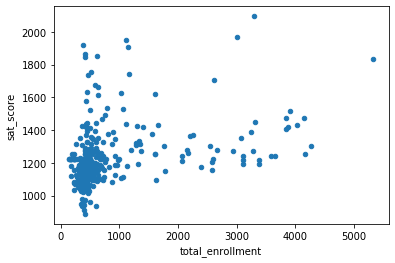

In [33]:
combined.plot.scatter(y="sat_score", x="total_enrollment")
plt.show()

From the graph above, it does not appear that there's an exremely strong correlation between sat_score and total_enrollment. However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of schools in this cluster so we can research them further.

In [34]:
low_enrollment = combined[combined["total_enrollment"] < 1000]

low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1300]

print(low_enrollment["School Name"])

0      HENRY STREET SCHOOL FOR INTERNATIONAL
1        UNIVERSITY NEIGHBORHOOD HIGH SCHOOL
2                 EAST SIDE COMMUNITY SCHOOL
3                    MARTA VALLE HIGH SCHOOL
6      47 THE AMERICAN SIGN LANGUAGE AND ENG
                       ...                  
357     ACADEMY FOR ENVIRONMENTAL LEADERSHIP
358    EBC HIGH SCHOOL FOR PUBLIC SERVICEBU
359       BUSHWICK SCHOOL FOR SOCIAL JUSTICE
360                ACADEMY OF URBAN PLANNING
362    BUSHWICK LEADERS HIGH SCHOOL FOR ACAD
Name: School Name, Length: 261, dtype: object


With a bit of Googling, we come to realize that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. We can explore this correlation with another plot. 

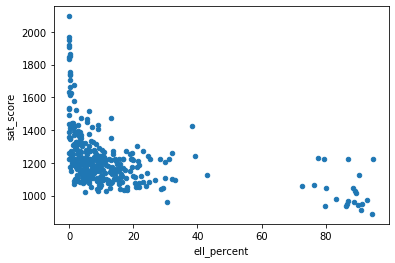

In [35]:
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there is still cluster of schools that have very high ell_percent values and low sat_scores values. This cluster represents the same group of international high schools we explored above. 

In order to explre the relationship, we'll want to map out ell_percent by school district. This map will show us which areas of city have a lot of English language learners. 

C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


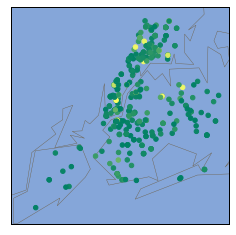

In [36]:
from mpl_toolkits.basemap import Basemap

# create a map that centers on New York City (llcrnrlat, urcrnrlat, llcrnrlon, and urcrnrlon define the corners of the geographic area the map depicts). 
# draw coastlines and rivers accordingly.
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution= 'i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# convert lon and lat column of combined to a list
longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

# draw scatter plot on basemap
# (s=20 to increase the size of points in the scatterplot) 
# (zorder=2 to plot the points on top of the rest of the map)
# (latlon=True) to indicate that we're passing in latitude and longitude coordinates, rather than axis coordinates
# (c: accepts a variable containing a sequence of numbers and assigns different colors to those numbers, 
# then shade the points on the plot associated with those numbers accordingly)
# (cmap="summer": color map in "summer", which results in green points for low numbers and yellow points for high numbers)
m.scatter(longitudes, latitudes, 
          s=20, 
          zorder=2, 
          latlon=True, 
          c=combined["ell_percent"], 
          cmap="summer")

plt.show()

This requires a bit of geographic knowledge. We see that school density is highest in Manhattan, and lower in Brooklyn, the Bronx, Queens and Staten Island. However, there are too many schools that makes it hard to interpret the map. Hence, instead of plot ell_percent school-by-school, we can plot ell_percent district-by-district. 

In [37]:
# find the average values of each column for each school district in combined
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  \
0                            135.800000     93.

C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


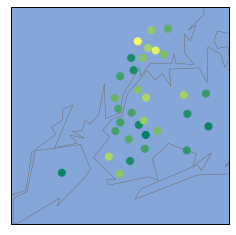

In [38]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution= 'i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, 
          s=50, 
          zorder=2, 
          latlon=True, 
          c=districts["ell_percent"], 
          cmap="summer")

plt.show()

### Exploring Safety and SAT scores

As mentioned above, the saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, corelated highly with sat_scores. 

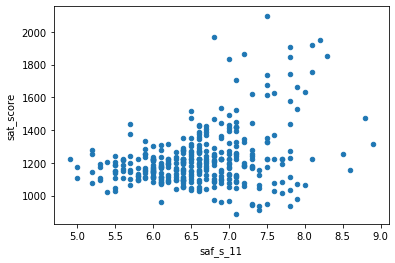

In [39]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it is not that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No schools with safety scores below 6.5 has an average SAT score higher than 1500 or so.

C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\Users\Little\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


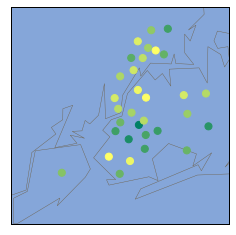

In [40]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution= 'i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, 
          s=50, 
          zorder=2, 
          latlon=True, 
          c=districts["saf_s_11"], 
          cmap="summer")

plt.show()

It looks like upper Manhattan and parts of Queen and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Exploring Race and SAT scores

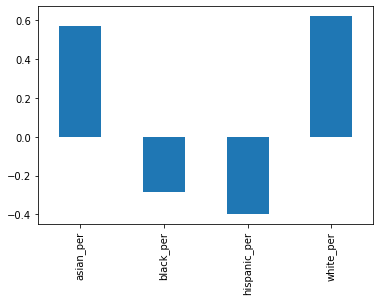

In [41]:
race_fields =["asian_per", "black_per", "hispanic_per", "white_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

As can be clearly seen from the graph above, Asian and White students' percentages correlate possitively with SAT scores, while it is the oppposite for black and hispanic students. This can be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

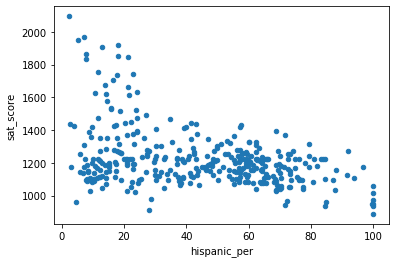

In [42]:
combined.plot.scatter("hispanic_per", "sat_score")

We can see a clear linear relationship between hispanic student percentage and SAT scores. We can also see that the majority falls under the spectrum of schools that have more than 90% of hispanic students. Meanwhile, those schools that have highest SAT scores fall under the category of schools have less than 10% hispanic students. 

In [43]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to primarily be geared towrds recent immigrants to the US. These schools have a lot of students who are learning English, which would explaun the lower SAT scores.

In [44]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1000)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
238                           BROOKLYN GENERATION SCHOOL
240              KURT HAHN EXPE

Many schools in this list are specialized for gifted students in arts, science, language, technology and social sciences, which receive extra funding and only admit students who pass the entrance exam. This does not explian low hispanic students, but explain why students score higher for SAT.

### Exploring Gender and SAT scores

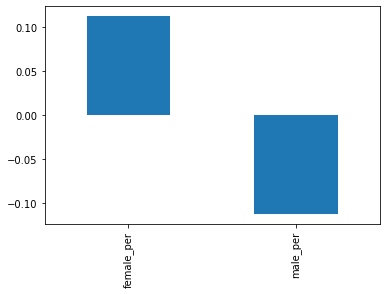

In [45]:
gender_fields = ["female_per", "male_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at school positively correlates with SAT scores, whereas a high percentage of males negatively correlates with SAT scores. Neither correlation is extremely strong.

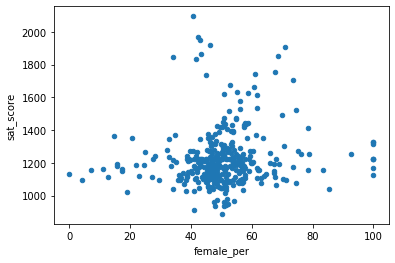

In [46]:
combined.plot.scatter("female_per", "sat_score")

There is 2 huge clusters of schools with high percentage of females with high SAT scores.

In [47]:
print(combined[(combined["female_per"] < 80) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be very selective liberal arts schools that have high academic standards, which result in high SAT scores.

### Exploring AP scores and SAT scores

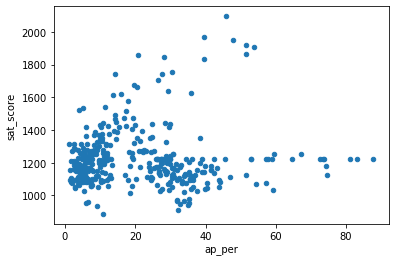

In [48]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"] *100

combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. It's not an extremely strong correlation, though. 

## CONCLUSION

After investigating into correlations among different factors that can possibly affect the SAT scores, we can jump to conclusion as following:
1. Geographic and SAT score:

We see that school density is highest in Manhattan, and lower in Brooklyn, the Bronx, Queens and Staten Island. At first, we believed that higher enrollments to schools lead to higher SAT scores, however, it is actually the percentage of English leaners that attributes to the total enrollments. Nevertheless, upper Manhattan and parts of the Bronx and Queens tend to have higher percentages of English learning students. 

2. Race and SAT score

There is quite strong correlation between races and SAT scores. Asian and white students perform quite good with high SAT scores, whereas schools that have high percentage of black or hispanic students tend to have lower performance on SAT scores. This could be due to the lack of funding, students are still learning English and not yet fully prepared for SAT exams. 

3. Gender and SAT score

Even though there is a correlation between genders and SAT scores, however, it is not that strong to have a huge influence on SAT scores. The statistics show that while schools that have high percentage of female students can have a higher SAT scores, schools with more male students tend to score lower. But it is not that necessarily true as the schools that have higher female percentage tend to be very selective schools and this could affect the scoring also. 

4. AP test takers and SAT score

There is also a correlation, and again, it is not that strong to have a huge influence on SAT scores. 

5. Safety and SAT score

There is quite a correlation between these 2 sections. And schools with quite low safety scores tend to score lower on SAT. 